## Data Wrangling/Cleaning/Feature Engineering

Hoping to get the columns (available columns)
1. Surface Size - "size":"1,500 sq ft"
2. Type of house - "propertyType":"Independent House",
3. Number of Bedrooms - "bedrooms":2
3. If the apartment comes furnished (binary) - can't find it in json
4. If the price is inclusive of utility bills (binary) - can't find it in json
5. Distance to City Center - 'latitude': 28.5949688, and 'longitude' are available.
6. Trendiness of the neighbourhood - ignored
7. Rental Agency (binary) -  'companyName': 'Rupak Properties Stock',
8. Target - price -  'price': 20000,

9. Added distance from AIIMS, CP, AIRPORT. Look at closest metro station distance. 
9. No. of bathrooms in listing html
10. Direction which it faces in html (could be imp - requires digging into the html again.)
11. Deposit in html
12. Furnishing Status in html (could be imp)

## To DO: 
1. Plot the listings on a map. (Done)
2. See if adding/augmenting with more data helps. (Doing, sort of helping.)
3. Add closest metro station Distance.(Done, The variability of results is down)
4. Add closest large hospital Distance. (Skipped for now)
5. Create New Notebook And Do Analyis and Final Model Fitting.(Log transformation and feature scaling done.)
6. Create clean pipeline for final Model.
6. Create a simple functions for prediction or webpage with inputs, problem with one-hot encoded input to model. !60 different values for locality, from dropdown, pick one then function creates input acc. to index.

In [46]:
# Get the Scraped data and Engineer features, data type transformation etc. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymongo
import os

In [58]:
rent_data= pd.read_csv('Data/Rent_data_makaan.csv', index_col=0)
# Index is messed up, doubled due to concatenating diff. dataframes. 
rent_data.reset_index(drop=True, inplace=True)

### Remove duplicate entries 

In [59]:
# removing aroung 600 duplicate entries.
print(f'{rent_data.duplicated().value_counts()[1]} Duplicates')
rent_data = rent_data[~rent_data.duplicated()]
rent_data.reset_index(drop=True, inplace=True)

627 Duplicates


In [55]:
rent_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6995 entries, 0 to 6994
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   size          6995 non-null   object 
 1   propertyType  6995 non-null   object 
 2   bedrooms      6995 non-null   int64  
 3   latitude      6995 non-null   float64
 4   longitude     6995 non-null   float64
 5   localityName  6995 non-null   object 
 6   suburbName    6995 non-null   object 
 7   cityName      6995 non-null   object 
 8   price         6995 non-null   int64  
 9   companyName   6995 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 546.6+ KB


#### Size column
1. Rename to include units.
2. split the value and unuit and Change data type to int.

In [20]:
rent_data.rename({'size': 'size_sq_ft'}, axis = 1, inplace=True)
rent_data.size_sq_ft = rent_data.size_sq_ft.str.replace(',', '',)
size = rent_data.size_sq_ft.str.split(' ', expand=True)[0]
rent_data.size_sq_ft = size
rent_data.size_sq_ft = rent_data.size_sq_ft.astype('int32')

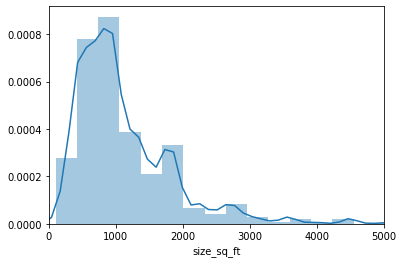

In [21]:
plt.xlim(0, 5000)
sns.distplot(rent_data.size_sq_ft, )
plt.show()

#### Property Type
Just 4 types, managebale for One-hot encoding or for Tree Based Methods.

In [22]:
rent_data.propertyType.value_counts()

Independent Floor    5058
Apartment            1647
Independent House     280
Villa                  10
Name: propertyType, dtype: int64

#### Bedrooms is already int and a quantitative continuous var.
Should be fine as is.

In [23]:
rent_data.bedrooms.value_counts()

2     2486
1     2042
3     2031
4      406
5       20
6        6
10       3
7        1
Name: bedrooms, dtype: int64

####  Latitude and Longitude
Look at geopy to get this working, and to get the extra features you need/want based on location.
Nice varied multimodal(different regions) distributions, cool.

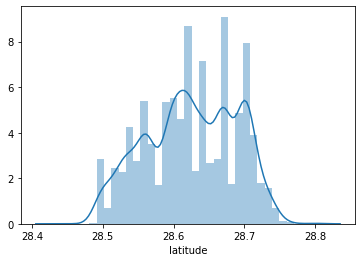

In [24]:
sns.distplot(rent_data.latitude)
plt.show()

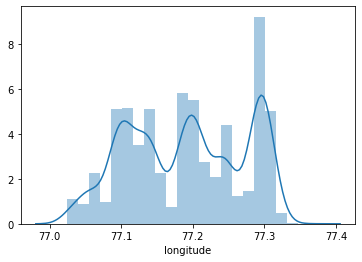

In [25]:
sns.distplot(rent_data.longitude)
plt.show()

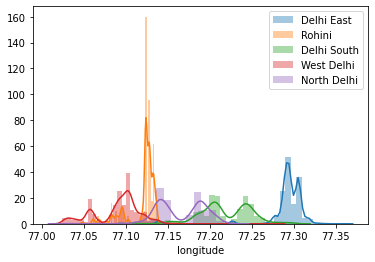

In [26]:
for item in rent_data.suburbName.unique():
    sns.distplot(rent_data.longitude.loc[rent_data.suburbName == item],label = item)
plt.legend()
plt.show()

### localityName
160 Values, have to get this down, lets filter < 5 as uncommon or drop ?.(96 now, just keep all) <br>
1. As Uncommon (IMplication for Input ? - Other can be mapped to Uncommon) -  
2. When Dropped -

In [27]:
rent_data.localityName.value_counts().loc[rent_data.localityName.value_counts() > 5]

Paschim Vihar          810
Pitampura              613
mayur vihar phase 1    516
New Ashok Nagar        389
Uttam Nagar            244
                      ... 
Golf Links               6
Vikas Marg               6
Sector 18 Rohini         6
Nirman Vihar             6
Nizamuddin East          6
Name: localityName, Length: 96, dtype: int64

In [28]:
#redundant = rent_data.localityName.value_counts().loc[rent_data.localityName.value_counts() < 5].index.to_list()

In [29]:
#for item in redundant:
#    rent_data.loc[(rent_data.localityName == item),['localityName']] = 'Uncommon'

#### cityName 
Useless column, drop.

In [30]:
rent_data.cityName.value_counts()

Delhi    6995
Name: cityName, dtype: int64

#### suburbName
Slight imbalance for a few Regions, that's okay though. Keep this column ? Train- Validation should be split by this colmun in similar ratio.

In [31]:
rent_data.suburbName.value_counts()

Delhi South    1887
West Delhi     1816
Delhi East     1754
North Delhi    1258
Rohini          280
Name: suburbName, dtype: int64

#### Price (monthly)
Already in int. Very Heavily skewed.(Outliers in target is a big problem)

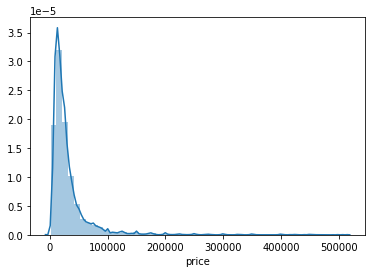

In [32]:
sns.distplot(rent_data.price )
plt.show()

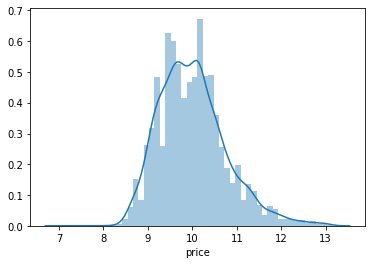

In [33]:
# Atempting to model with log of price.
sns.distplot(np.log(rent_data.price))
plt.show()

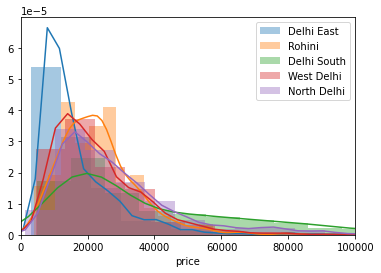

In [34]:
plt.xlim(0,100000)
for item in rent_data.suburbName.unique():
    sns.distplot(rent_data.price.loc[rent_data.suburbName == item], label = item)
plt.legend()
plt.show()

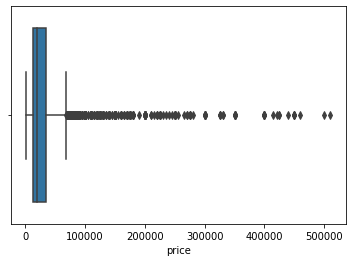

In [35]:
#plt.xlim(0, 200000)
sns.boxplot(rent_data.price )
plt.show()

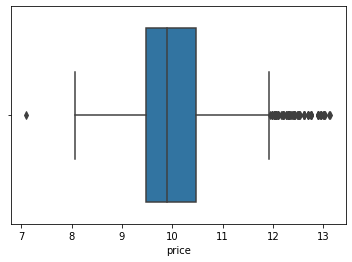

In [36]:
sns.boxplot(np.log(rent_data.price))
plt.show()

In [37]:
log_price = np.log(rent_data.price)

In [38]:
rent_data['price'] = log_price

#### Company Name 
The agent/Realtor - 515 values.<br>
With a minimum of 5 listings leaves us with 168 values.<br>
With a minimum of 10 listings leaves us with 133 values.<br>
Encoded people with fewer listings as 'independent' - (802 listings with independent)

In [39]:
rent_data.companyName.value_counts().loc[rent_data.companyName.value_counts() > 10]

Jagdamba Associates       247
Arora Associates          233
Prince Associates         146
Guru kipra properties     136
A 2 Z Property            127
                         ... 
Shubham Home Solutions     12
chopra build well          12
Jrr Realtors Pvt Ltd       11
BM PROPERTIES              11
Dream house properties     11
Name: companyName, Length: 133, dtype: int64

In [40]:
redundant = rent_data.companyName.value_counts().loc[rent_data.companyName.value_counts() < 10].index.to_list()

In [41]:
for item in redundant:
    rent_data.loc[(rent_data.companyName == item),['companyName']] = 'Independent'

### Visualising Rent Market Trends
Using gmaps API. heat map layer that will tell us where the highest rents of the city are. <br>
API key in environment Variable. 

In [42]:
import gmaps
gmaps.configure(api_key=os.environ["GOOGLE_API_KEY"])

In [44]:
fig = gmaps.figure()

heatmap_layer = gmaps.heatmap_layer(rent_data[['latitude', 'longitude']], 
                                   weights = rent_data['price'], 
                                    max_intensity = np.log(200000),
                                    point_radius=6.0)

fig.add_layer(heatmap_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [174]:
fig = gmaps.figure()

heatmap_layer = gmaps.heatmap_layer(rent_data[['latitude', 'longitude']], 
                                   weights = rent_data['price'], 
                                    max_intensity = 200000,
                                    point_radius=6.0)

fig.add_layer(heatmap_layer)
fig

Figure(layout=FigureLayout(height='420px'))

### Metro stations data
Grabbing nearest metro station distance :
1. Current implementation is getting distances for all listing from all the stations and keeping nearest. Calc - keep - filter
2. Do in single function: Calc - filter - keep

In [47]:
# import pymongo
client = pymongo.MongoClient('mongodb://127.0.0.1:27017/')
db = client['Makaan_rental_listings']
metro_data = db.Delhi_metro_stations

In [48]:
# Flatten JSON 
metro_data = pd.json_normalize(list(metro_data.find()))

In [49]:
fig = gmaps.figure()

heatmap_layer = gmaps.heatmap_layer(metro_data[['details.latitude', 'details.longitude']])
heatmap_layer.gradient = [
    (200, 200, 200, 0),
    (0, 0, 255, 1),
    (0, 0, 255, 1)]

heatmap_layer_1 = gmaps.heatmap_layer(rent_data[['latitude', 'longitude']], 
                                   weights = rent_data['price'], 
                                    max_intensity = 200000,
                                    point_radius=6.0)


fig.add_layer(heatmap_layer)
fig.add_layer(heatmap_layer_1)


fig

Figure(layout=FigureLayout(height='420px'))

In [582]:
metro_data['Coordinates'] = metro_data['details.latitude'].astype(str) + ',' + metro_data['details.longitude'].astype(str)

In [648]:
# Extremely slow function, go grab dinner. Improve later 
temp = rent_data.copy()

for i,item in enumerate(metro_data.name.to_list()[:]):
    temp = calc_dist(temp, metro_data['Coordinates'].str.split(',').iloc[i], item)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Completed_Pass in 3.6843600273132324 Seconds
Completed_Pass in 3.52484393119812 Seconds
Completed_Pass in 3.631027936935425 Seconds
Completed_Pass in 3.715977907180786 Seconds
Completed_Pass in 3.941168785095215 Seconds
Completed_Pass in 3.7260890007019043 Seconds
Completed_Pass in 3.766896963119507 Seconds
Completed_Pass in 3.6363141536712646 Seconds
Completed_Pass in 3.5463969707489014 Seconds
Completed_Pass in 3.6225380897521973 Seconds
Completed_Pass in 3.7123849391937256 Seconds
Completed_Pass in 3.6832239627838135 Seconds
Completed_Pass in 3.852293014526367 Seconds
Completed_Pass in 3.6614840030670166 Seconds
Completed_Pass in 3.848217010498047 Seconds
Completed_Pass in 4.772636890411377 Seconds
Completed_Pass in 5.9559547901153564 Seconds
Completed_Pass in 5.799846887588501 Seconds
Completed_Pass in 5.299943923950195 Seconds
Completed_Pass in 3.989423990249634 Seconds
Completed_Pass in 5.361371278762817 Seconds
Completed_Pass in 3.9847521781921387 Seconds
Completed_Pass in 4.243

Completed_Pass in 5.16392707824707 Seconds
Completed_Pass in 6.276181936264038 Seconds
Completed_Pass in 4.228852033615112 Seconds
Completed_Pass in 3.7877349853515625 Seconds
Completed_Pass in 3.9362800121307373 Seconds
Completed_Pass in 4.338251113891602 Seconds
Completed_Pass in 4.707863807678223 Seconds
Completed_Pass in 4.934067010879517 Seconds
Completed_Pass in 4.912569761276245 Seconds
Completed_Pass in 6.713587045669556 Seconds
Completed_Pass in 3.980476140975952 Seconds
Completed_Pass in 4.683915138244629 Seconds
Completed_Pass in 5.48007607460022 Seconds
Completed_Pass in 5.137398958206177 Seconds
Completed_Pass in 4.236294984817505 Seconds
Completed_Pass in 4.29990291595459 Seconds
Completed_Pass in 3.910822868347168 Seconds
Completed_Pass in 6.0516040325164795 Seconds
Completed_Pass in 4.717060089111328 Seconds
Completed_Pass in 3.804049015045166 Seconds
Completed_Pass in 3.91473388671875 Seconds
Completed_Pass in 3.9393599033355713 Seconds
Completed_Pass in 5.115566968917

In [663]:
rent_data['closest_mtero_station_km'] = temp.iloc[:,10:].min(axis = 1)

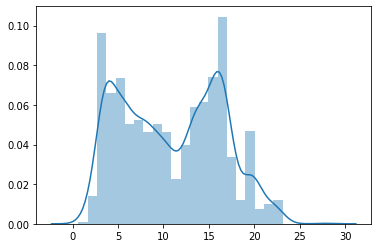

In [666]:
sns.distplot(temp.iloc[:, -2:].min(axis = 1))

### Bi-Variate Analysis 
### Multi-Variate Analysis 
### Data Interaction 

## Feature Engineering 
## (GeoPY) Goelocation - Distance from Airport, AIIMS, CP.

### Airport - Centre Point	28.55489735,77.08467458266915

In [27]:
Airport = (28.55489735, 77.08467458266915)
Aiims =( 28.5668602,77.2078058)
CP = (28.6313827,77.2197924) # Practically useless 
NDLS_railway = (28.6417, 77.2207)

In [28]:
from geopy.distance import geodesic
from time import time

def calc_dist(rent_data_df, coord, name):
    """Calculates the distance of each listing from given coordinates and createa a
    column in the Df with prefix name_.
    coord is a tuple of lat and lon and are floats. name is a string.
    """
    rent_data_df[name + '_dist_km'] = 0.0
    
    tic = time()
    for i in range(len(rent_data_df)):
        rent_data_df[name + '_dist_km'][i] = geodesic(rent_data['latitude'][i].astype(str) + ',' + rent_data['longitude'][i].astype(str),
                                                   str(coord[0]) + ',' + str(coord[1])).km        
    print(f'Completed_Pass in {time() - tic} Seconds')
    return rent_data_df

In [30]:
rent_data = calc_dist(rent_data, Airport, 'AP')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Completed_Pass in 4.054443120956421 Seconds


In [31]:
rent_data = calc_dist(rent_data, Aiims, 'Aiims')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Completed_Pass in 6.24465799331665 Seconds


In [29]:
rent_data = calc_dist(rent_data, NDLS_railway, 'NDRLW')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Completed_Pass in 4.923648118972778 Seconds


### Collinearity - Checking Correlations between predictor vars. 
Collinearity is when the predictors are correlated. For ex, the size of the house and the number of bedrooms. <br>
I'm not getting definite answers but multicollinearity doesn't seem to be a problem for Random Forest etc. and is a consideration mainly for regression analysis.<br>
Drop Bedrooms, latitude and Longitude.

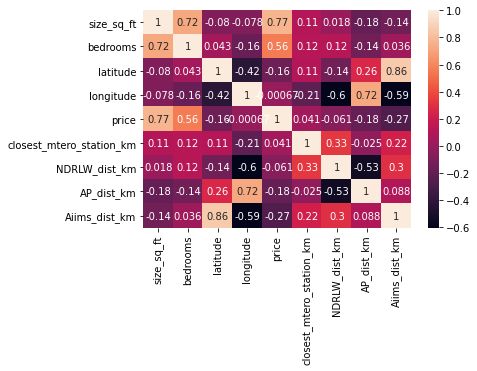

In [32]:
sns.heatmap(rent_data.corr(method='pearson'), annot=True)

## Modelling
1. dirty attempt with no regards to proper splitting. (about .60 r^2 score with cv). Just Using area and bedroom.
2. Lets add suburbName to the mix.(5 Encoded columns ) r^2 Score : 0.68
3. PropertyType - (4 encoded columns): 0.66, std 0.1
4. LocalityName - (160 values): 0.79, std = 0.78
5. Collinearity - Just drop a column(Bedrooms): 0.7899, std = 0.09 (Similar accuracy, much lower stdev) (MAE - -7090)
6. Collinearity - Create a mixture of the offending Collumns(surface per bedroom - it seems like this'll loose the info about the size of the house ? seems like this would be misleading. - Absolutely correct looses a lot of info): 0.537 std = 0.11
7. a. MultiCOllinearity ? - The suburb name and locaility names have similar data - drop suburb name. : 0.72 std 0.12
7. b. The same but with bedrooms dropped.: 0.74 std 0.10
8. Add company/dealer.(Improves scores but this is a contraint, limits model, also, with these many features 313, it is extremely slow) 0.80 std 0.0738 (MAE - -6608)
9. Modelling should be done by now, with the available data, move on to more data or XGBoost. OR splitting by the district in a better ratio.(not needed)
10. Distance from airport added.(This model now uses lat, long so another constraint added for input by user, can ask Km's from AP but that makes the Algo seem dumb) 0.76 std 0.06 (MAE -7121.346641305841)
11. Distance from AIIMS Delhi and CP. 0.753 std 0.067 (MAE - -6933.305912927501 698.9)

#### Performance Log
1. After removing duplicates and approach 5 (No company name).CV- Train :0.74 std  0.10, Train MAE : 7411 , MSE :  375454635, Test set : 0.76.
2. After removing duplicates and approach 9(With Company Name). CV- Train : 0.75 std 0.07, Train MAE : 7339 , MSE : 409066679, Test set : 0.85. 
3. Added Distance from Airport CV- Train : 0.7514 std 0.06. Train MAE : -7595. MSE : 410337141. Test Set 0.76.
4. Added Distance from AIIMS CV Train : 0.77 std 0.08. Train MAE - 7501 MSE - 352156603. Test Set 0.72
5. Added Distance from CP Train : 0.705 Std 0.0607. Train MAE - 7620 MSE - 435806285. Test Set 0.81
6. With all Metro data. CV Train 0.759 std 0.08. Test Set 0.757
7. Closest Metro Station. CV Train: 0.743 std 0.059. Train MAE - 7413 MSE - 384380646. Test Set 0.73.
8. Aiims 0.775 std 0.06, MAE 7640 MSE 345675776
9. (Just select this) Aiims + Airport + RLW CV Train: 0.733 std 0.04. Train MAE 7557 MSE 416968776. Test Set 0.77
10. With Company Name. CV Train: 0.80 std 0.05. Train MAE 6791 MSE 292907031. Test Set 0.77
11. With the target(price) log transformed. Cannot directly compare training r2, MAE, RMSE as the target has been transformed. Random Forest-  After inverse transforming predictions and taking R2 - Test Set 0.784 (so Maybe Improvement ?)
13. Scale(standardise) all data and log transform target. Random Forest-  After inverse transforming predictions and taking R2 - Test Set 0.792.

In [101]:
# Creating copy of dataframe. 

temp = rent_data.copy()

In [102]:
# for attempy 5
temp.drop(['bedrooms'], axis = 1, inplace = True)

In [103]:
# skip this step for attempt 7 only

temp = pd.concat([temp,pd.get_dummies(temp.suburbName, prefix='sN_')], axis = 1)

In [104]:
temp.drop(['suburbName'], axis = 1, inplace=True)

In [105]:
temp = pd.concat([temp,pd.get_dummies(temp.propertyType, prefix='pT_')], axis = 1)

In [106]:
temp.drop(['propertyType'], axis = 1, inplace=True)

In [107]:
temp = pd.concat([temp,pd.get_dummies(temp.localityName, prefix='lN_')], axis = 1)
temp.drop(['localityName'], axis = 1, inplace=True)

In [790]:
# for attemp 8 only companyName
#temp = pd.concat([temp,pd.get_dummies(temp.companyName, prefix='cN_')], axis = 1)
#temp.drop(['companyName'], axis = 1, inplace=True)

In [108]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, SCORERS
#sorted(SCORERS.keys())

In [109]:
labels = temp.price

In [110]:
len(temp.columns)

179

In [111]:
temp.drop(['price'], axis = 1, inplace=True)

In [112]:
columns = ['size_sq_ft', 'bedrooms', 'sN__Delhi East', 'sN__Delhi South', 'sN__North Delhi', 'sN__Rohini',
           'sN__West Delhi', 'pT__Apartment', 'pT__Independent Floor', 'pT__Independent House', 'pT__Villa']

# With so many columns just drop the ones you don't want.
drop_cols = ['latitude', 'longitude', 'cityName', 'companyName']

In [794]:
# for attempt 8. 
#drop_cols = ['latitude', 'longitude', 'cityName']

In [125]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
scale.fit(temp.drop(drop_cols, axis = 1))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [126]:
x_train, x_test, y_train, y_test = train_test_split(scale.transform(temp.drop(drop_cols, axis = 1))
                                                    , labels, test_size = .30,
                                                   shuffle = True)

#### Train- test Balance for suburbName
The balance is fine, Trust the random process child.

In [127]:
print(x_train['sN__Delhi East'].value_counts()[1]/x_train['sN__Delhi East'].value_counts()[0])
print(x_test['sN__Delhi East'].value_counts()[1]/x_test['sN__Delhi East'].value_counts()[0])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [94]:
print(x_train['sN__Delhi South'].value_counts()[1]/x_train['sN__Delhi South'].value_counts()[0])
print(x_test['sN__Delhi South'].value_counts()[1]/x_test['sN__Delhi South'].value_counts()[0])

0.3683622135271101
0.3718954248366013


In [95]:
print(x_train['sN__North Delhi'].value_counts()[1]/x_train['sN__North Delhi'].value_counts()[0])
print(x_test['sN__North Delhi'].value_counts()[1]/x_test['sN__North Delhi'].value_counts()[0])

0.22369407648087977
0.20910138248847926


In [96]:
print(x_train['sN__Rohini'].value_counts()[1]/x_train['sN__Rohini'].value_counts()[0])
print(x_test['sN__Rohini'].value_counts()[1]/x_test['sN__Rohini'].value_counts()[0])

0.04059511158342189
0.044278606965174126


In [831]:
print(x_train['sN__West Delhi'].value_counts()[1]/x_train['sN__West Delhi'].value_counts()[0])
print(x_test['sN__West Delhi'].value_counts()[1]/x_test['sN__West Delhi'].value_counts()[0])

0.34468552595440816
0.3647594278283485


In [832]:
# some naive metric to see if enough data for features, 5 samples per feature.
x_train.shape[0]/x_train.shape[1]

28.137931034482758

#### Random Forest
Predictions tend to do underestimate the prices, Outliers are a big problem. 

In [128]:
rf = RandomForestRegressor(n_estimators=100,
                          criterion = 'mse', max_depth = None, oob_score = True, n_jobs = -1)

In [129]:
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [131]:
cv_score = cross_val_score(rf, x_train, y_train, cv = 10, scoring='r2', n_jobs=-1, verbose = True)
print(np.mean(cv_score), np.std(cv_score))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.8395800844460192 0.02626839143216422


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.6s finished


In [130]:
rf.score(x_test, y_test)

0.8736744526739075

In [132]:
test_pred = rf.predict(x_test)

In [133]:
print(r2_score(np.exp(y_test), np.exp(test_pred)))

0.7927220261992669


In [120]:
cv_score = cross_val_score(rf, x_train, y_train, cv = 10, scoring='neg_mean_absolute_error', n_jobs=-1)
print(np.mean(cv_score), np.std(cv_score))

-0.19820810376110115 0.012249695004910719


In [121]:
mse_val_score = cross_val_score(rf, x_train, y_train, cv = 10, scoring='neg_mean_squared_error', n_jobs=-1)
print(np.mean(mse_val_score), np.std(mse_val_score))

-0.08187369479507148 0.01105216908646111


### XGBoost Regressor 

In [135]:
from xgboost import XGBRegressor

In [136]:
model = XGBRegressor(n_estimators = 1000,learning_rate=0.05,max_depth=6, n_jobs = 4, objective='reg:squarederror')
                     #, eval_metric= 'mae')

In [137]:
model.fit(x_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(x_test, y_test)],
             verbose=True)

[0]	validation_0-rmse:9.07309
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:8.62130
[2]	validation_0-rmse:8.19226
[3]	validation_0-rmse:7.78440
[4]	validation_0-rmse:7.39683
[5]	validation_0-rmse:7.02903
[6]	validation_0-rmse:6.67913
[7]	validation_0-rmse:6.34685
[8]	validation_0-rmse:6.03153
[9]	validation_0-rmse:5.73189
[10]	validation_0-rmse:5.44733
[11]	validation_0-rmse:5.17683
[12]	validation_0-rmse:4.92013
[13]	validation_0-rmse:4.67616
[14]	validation_0-rmse:4.44442
[15]	validation_0-rmse:4.22435
[16]	validation_0-rmse:4.01534
[17]	validation_0-rmse:3.81682
[18]	validation_0-rmse:3.62846
[19]	validation_0-rmse:3.44924
[20]	validation_0-rmse:3.27948
[21]	validation_0-rmse:3.11815
[22]	validation_0-rmse:2.96489
[23]	validation_0-rmse:2.81924
[24]	validation_0-rmse:2.68078
[25]	validation_0-rmse:2.54967
[26]	validation_0-rmse:2.42486
[27]	validation_0-rmse:2.30657
[28]	validation_0-rmse:2.19423
[29]	validation_0-rmse:2.08755
[30]	validation_

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=4, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [138]:
model.score(x_test, y_test)

0.8758045525015435

In [139]:
print(r2_score(np.exp(y_test.to_list()), np.exp(test_pred)))

0.7927220261992669


In [140]:
test_pred = model.predict(x_test)

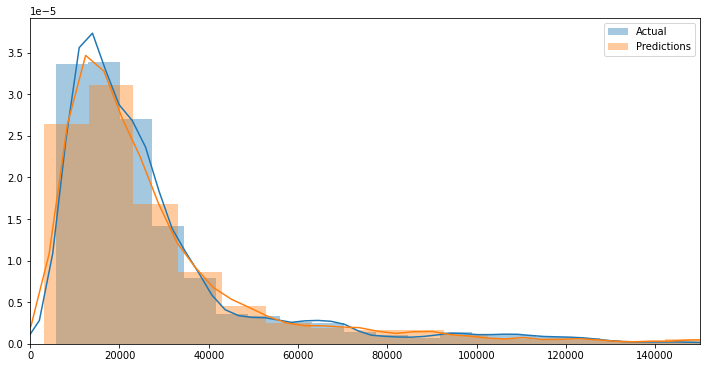

In [141]:
plt.figure(figsize=(12,6))
plt.xlim(0, 150000)
sns.distplot(np.exp(test_pred), label = 'Actual')
sns.distplot(np.exp(y_test.to_list()), label='Predictions')
plt.legend()
plt.show()

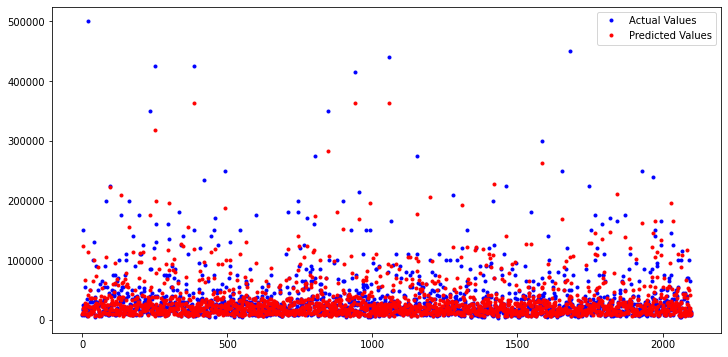

In [142]:
plt.figure(figsize=(12,6))
plt.plot(np.exp(y_test.to_list()), 'b.', label = 'Actual Values')
plt.plot(np.exp(test_pred), 'r.', label = 'Predicted Values')
plt.legend()
plt.show()

#### Feature Importance

In [143]:
cols = x_train.columns
imp = model.feature_importances_

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [94]:
feat_imp = pd.DataFrame(data = imp, index=cols)

In [95]:
feat_imp.sort_values(by = 0, ascending=False).head(20)

,0
size_sq_ft,0.260807
lN__Ashok Vihar,0.052132
Aiims_dist_km,0.038146
lN__Karol Bagh,0.031745
sN__North Delhi,0.027013
sN__Delhi East,0.020573
lN__Preet Vihar,0.018441
sN__Delhi South,0.018392
lN__Paschim Vihar,0.018382
lN__Gujranwala Town,0.017195
